<a href="https://colab.research.google.com/github/osamja/zero-to-hero/blob/main/lecture_3/MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [241]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

- Cheatsheet: https://github.com/karpathy/nn-zero-to-hero/blob/master/lectures/makemore/makemore_part2_mlp.ipynb


In [242]:
# !wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt    # Uncomment to download names.txt
names = open('names.txt', 'r').read().splitlines()

In [243]:
# Create a dictionary of characters and their indices
chars = sorted(list(set(''.join(names))))
char2idx = {c: i+1 for i, c in enumerate(chars)}
idx2char = {i+1: c for i, c in enumerate(chars)}

char2idx['.'] = 0  # ? andrej has this set to zero but doesn't that replace the first character in the alphabet?
idx2char[0] = '.'

In [244]:
# Build the dataset
block_size = 3 # context length: how many characters to consider before predicting the next character
X, Y = [], []

for name in names[:1]:
    name = name + '.'
    context = [0] * block_size      # The first context is a block of zeros which enables padding
    for c in name:
        X.append(context)
        Y.append(char2idx[c])      # The next character is context[-1] (the last character in the context)
        # print(''.join([idx2char[i] for i in context]), '->', c)
        context = context[1:] + [char2idx[c]]   # Crop & shift the context by one character
        
X = torch.tensor(X, dtype=torch.long)   # Should we be using long or ints?
Y = torch.tensor(Y, dtype=torch.long)

num_examples = X.shape[0]
print('Number of examples:', num_examples)

Number of examples: 5


In [245]:
# Embed the characters
x_enc = torch.nn.functional.one_hot(X, num_classes=27).float()
x_enc.shape

C = torch.randn((27, 2))    # Two dimensional embedding
C[5] == F.one_hot(torch.tensor(5), num_classes=27).float() @ C


tensor([True, True])

In [246]:
# wow this array indexing is so cool
emb = C[X]
emb.shape

torch.Size([5, 3, 2])

In [247]:
emb[2][2]

tensor([ 0.8730, -0.6262])

In [248]:
# construct the hidden layer
W1 = torch.randn(6, 100)
b1 = torch.randn(100)

In [249]:
res = emb.reshape(5, 6)
res

tensor([[-0.1277, -0.1120, -0.1277, -0.1120, -0.1277, -0.1120],
        [-0.1277, -0.1120, -0.1277, -0.1120, -1.4580, -1.0950],
        [-0.1277, -0.1120, -1.4580, -1.0950,  0.8730, -0.6262],
        [-1.4580, -1.0950,  0.8730, -0.6262,  0.8730, -0.6262],
        [ 0.8730, -0.6262,  0.8730, -0.6262, -0.2593, -1.1318]])

In [250]:
emb.view(5, 6)

tensor([[-0.1277, -0.1120, -0.1277, -0.1120, -0.1277, -0.1120],
        [-0.1277, -0.1120, -0.1277, -0.1120, -1.4580, -1.0950],
        [-0.1277, -0.1120, -1.4580, -1.0950,  0.8730, -0.6262],
        [-1.4580, -1.0950,  0.8730, -0.6262,  0.8730, -0.6262],
        [ 0.8730, -0.6262,  0.8730, -0.6262, -0.2593, -1.1318]])

In [251]:
# -1 means "whatever is needed to make the shape work"- copilot. haha same as num_examples
emb.view(-1, 6) == emb.reshape(num_examples, 6) 

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True]])

In [252]:
# calculate the hidden layer
h = emb.view(5, 6) @ W1 + b1
h = torch.tanh(h)
h.min(), h.max()

(tensor(-1.0000), tensor(1.0000))

In [253]:
# create the output layer
W2 = torch.randn(100, 27)
b2 = torch.randn(27) 

logits = h @ W2 + b2

In [254]:
logits.shape

torch.Size([5, 27])

In [255]:
# Let's get our fake counts and then normalize them into a probability distribution
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
prob.shape, prob.sum(1)

(torch.Size([5, 27]), tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000]))

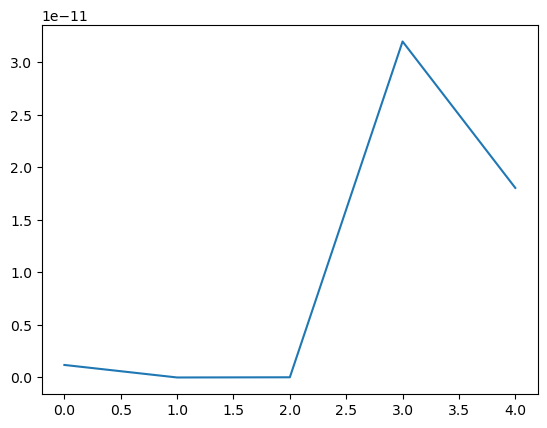

In [256]:
# Lets use y to get the actual probability
pr_dist = prob[torch.arange(num_examples), Y]
plt.plot(pr_dist)

In [257]:
# Now we can calculate the loss
loss = -torch.log(pr_dist).mean()
loss

tensor(29.7288)

In [258]:
F.cross_entropy(logits, Y)  # This is the same as the above

tensor(29.7288)

Epoch: 0, Loss: 17.555978775024414
Epoch: 100, Loss: 3.6845951080322266
Epoch: 200, Loss: 2.701594114303589
Epoch: 300, Loss: 2.586404800415039
Epoch: 400, Loss: 2.598540782928467
Epoch: 500, Loss: 2.6223936080932617
Epoch: 600, Loss: 2.5675251483917236
Epoch: 700, Loss: 2.4360511302948
Epoch: 800, Loss: 2.195204973220825
Epoch: 900, Loss: 2.57855486869812
Number of parameters: 398


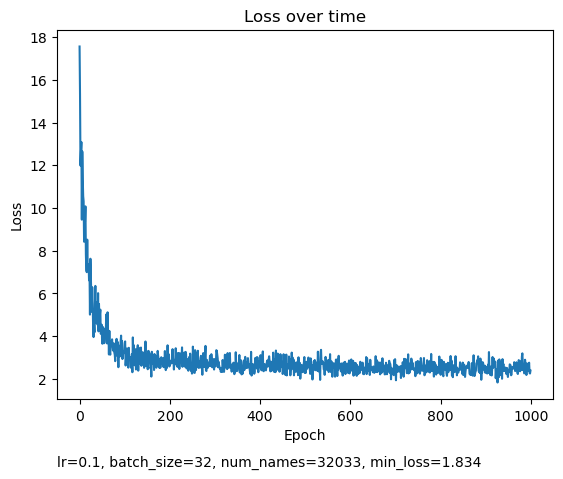

In [375]:
 # Create a function to train the model
def train(names, lr=0.1, epochs=1000, batch_size=32):
    loss_counts = []
    num_names = len(names)

    # Create a dictionary of characters and their indices
    chars = sorted(list(set(''.join(names))))
    char2idx = {c: i+1 for i, c in enumerate(chars)}
    idx2char = {i+1: c for i, c in enumerate(chars)}
    char2idx['.'] = 0  # ? andrej has this set to zero but doesn't that replace the first character in the alphabet?
    idx2char[0] = '.'

    # Build the dataset
    block_size = 3 # context length: how many characters to consider before predicting the next character
    X, Y = [], []

    for name in names[:num_names]:
        name = name + '.'
        context = [0] * block_size      # The first context is a block of zeros which enables padding
        for c in name:
            X.append(context)
            Y.append(char2idx[c])      # The next character is context[-1] (the last character in the context)
            # print(''.join([idx2char[i] for i in context]), '->', c)
            context = context[1:] + [char2idx[c]]   # Crop & shift the context by one character
            
    X = torch.tensor(X, dtype=torch.long)   # Should we be using long or ints?
    Y = torch.tensor(Y, dtype=torch.long)
    C = torch.randn((27, 2))    # Two dimensional embedding
    emb = C[X]

    # construct the hidden layer
    W1 = torch.randn(6, 100)
    b1 = torch.randn(100)

    # construct the output layer
    W2 = torch.randn(100, 27)
    b2 = torch.randn(27) 
    
    # Set the parameters to require gradients
    parameters = [W1, b1, W2, b2, C]
    for p in parameters:
        p.requires_grad = True
    
    # Forward pass
    for epoch in range(epochs):
        # Get a random batch of names
        rand_batch_idx = torch.randint(0, num_names, (batch_size,))
        x_batch = X[rand_batch_idx]
        y_batch = Y[rand_batch_idx]

        # Embed the characters
        emb = C[x_batch]
        emb = emb.view(batch_size, 6)

        # Calculate the hidden layer
        h = torch.tanh(emb @ W1 + b1)
        logits = h @ W2 + b2

        # Calculate the loss
        loss = F.cross_entropy(logits, y_batch)
        loss_counts.append(loss.item())
        
        # Backward pass
        loss.backward()
        
        # Update the weights
        with torch.no_grad():
            W1 -= lr * W1.grad
            b1 -= lr * b1.grad
            W2 -= lr * W2.grad
            b2 -= lr * b2.grad
            C -= lr * C.grad
            
        # Zero the gradients
        W1.grad.zero_()
        b1.grad.zero_()
        W2.grad.zero_()
        b2.grad.zero_()
        C.grad.zero_()
        
        if epoch % 100 == 0:
            print(f'Epoch: {epoch}, Loss: {loss.item()}')

    # Calculate the number of parameters
    batch_parameters = [W1, b1, W2, b2, emb]
    num_parameters = 0
    for p in batch_parameters:
        for s in p.shape:
            num_parameters += s
    print('Number of parameters:', num_parameters)

    # Plot the loss
    plt.plot(loss_counts)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss over time')
    plt.annotate(f'lr={lr}, batch_size={batch_size}, num_names={num_names}, min_loss={min(loss_counts):.3f}', (0, 0), (0, -40), xycoords='axes fraction', textcoords='offset points', va='top')

    # Return the trained parameter weighst
    return [C, W1, b1, W2, b2]

names = open('names.txt', 'r').read().splitlines()
weights = train(names)

In [337]:
[C, W1, b1, W2, b2] = weights
C.shape

torch.Size([27, 2])

In [374]:
# Sample from the model
def sample(C, W1, b1, W2, b2, num_names=10):
    context = [0] * 3
    generated_names = []
    for i in range(num_names):
        # Sample a name from the starting context character (.)
        context = [0] * 3
        emb = C[context]
        name = ''
        while True:
            # Embed the characters
            emb = C[context]
            emb = emb.view(-1, 6)

            # Calculate the hidden layer
            h = torch.tanh(emb @ W1 + b1)
            logits = h @ W2 + b2

            # Sample from the output layer
            probs = logits.exp() / logits.exp().sum()
            idx = torch.multinomial(probs, 1)

            # Check if we're done
            if idx2char[idx.item()] == '.':
                generated_names.append(name)
                break

            # Add the character to the name
            name += (idx2char[idx.item()])

            # Update the context
            context = context[1:] + [idx.item()]
    
    return generated_names

sample(C, W1, b1, W2, b2)

['ezyon',
 'sareroe',
 'voe',
 'japoyn',
 'belhe',
 'nna',
 'egefe',
 'calin',
 'kazec',
 'cein']

### Sample names
```
['ezyon',
 'sareroe',
 'voe',
 'japoyn',
 'belhe',
 'nna',
 'egefe',
 'calin',
 'kazec',
 'cein']
```

These names are 'name like' but I would've expected slightly better given we've traind on three context charactesr.